In [121]:
import numpy as np
import pandas as pd
import sympy as sp

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy.integrate import solve_ivp
from scipy.special import expi

from IPython.display import display, Latex

# Task 1

Applying the specified methods, implement algorithms for the numerical solution of a differential equation
$$
    y' = 0.2y + \frac{0.8}{x}
$$
with an initial condition $y(1) = 2$ on an interval $[1,10]$.


In [122]:
# Define IVP properties
def f(x, y):
    return 0.2 * y + 0.8 / x


Y0 = 2.0
START = 1.0
END = 10.0

MESH = 1000

# Step size. Depends on mesh refinement
def h(m=MESH):
    return (END - START) / m


### Euler Method

In [123]:
h_euler = h(25)

X_euler = np.linspace(START, END, 25)
Y_euler = np.zeros(len(X_euler))
Y_euler[0] = Y0

for i in range(len(X_euler) - 1):
    yi = Y_euler[i]
    xi = X_euler[i]

    # Euler formula
    Y_euler[i + 1] = yi + h_euler * f(xi, yi)

### Runge-Kutta Method

In [124]:
h_rk = h(MESH)

X_rk = np.linspace(START, END, MESH)
Y_rk = np.zeros(len(X_rk))
Y_rk[0] = Y0

for i in range(len(X_rk) - 1):
    xi = X_rk[i]
    yi = Y_rk[i]

    k1 = f(xi, yi)
    k2 = f(xi + h_rk / 2, yi + h_rk / 2 * k1)
    k3 = f(xi + h_rk / 2, yi + h_rk / 2 * k2)
    k4 = f(xi + h_rk, yi + h_rk * k3)

    Y_rk[i + 1] = yi + h_rk / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

### Adams-Bashforth-Moulton Method

In [125]:
h_adam = h(MESH)

X_adam = np.linspace(START, END, MESH)
Y_adam = np.zeros(len(X_adam))

# Take first four points from the results of Runge-Kutta method
for i in range(0, 4):
    Y_adam[i] = Y_rk[i]

for i in range(3, len(X_adam) - 1):
    xi, xi1, xi2, xi3 = X_adam[i], X_adam[i - 1], X_adam[i - 2], X_adam[i - 3]
    yi, yi1, yi2, yi3 = Y_adam[i], Y_adam[i - 1], Y_adam[i - 2], Y_adam[i - 3]

    fi  = f(xi,  yi)
    fi1 = f(xi1, yi1)
    fi2 = f(xi2, yi2)
    fi3 = f(xi3, yi3)

    # Adams–Bashforth predictor
    y_pred = yi + h_adam / 24 * (-9 * fi3 + 37 * fi2 - 59 * fi1 + 55 * fi)

    f_pred = f(X_adam[i + 1], y_pred)

    # Adams–Moulton corrector
    Y_adam[i + 1] = yi + h_adam / 24 * (fi2 - 5 * fi1 + 19 * fi + 9 * f_pred)

### Cauchy Problem

We use`scipy` toolkit to spolve ODE.

In [126]:
X_exact = np.linspace(START, END, MESH)

sol = solve_ivp(
    f, (START, END), [2],
    t_eval=X_exact,
    method="RK45",  # Runga-Kutta method of order 4-5
    rtol=1e-9,
    atol=1e-12
)

Y_exact = sol.y[0]

### Analytical Solution

In [127]:
def y_analytical(x):
    return 2 * np.exp((x - 1) / 5) + 4/5 * np.exp(x / 5) * (expi(-x / 5)
                                                            - expi(-1 / 5))


X_analytical = np.linspace(START, END, MESH)
Y_analytical = [y_analytical(x) for x in X_analytical]

### Graphical Plot

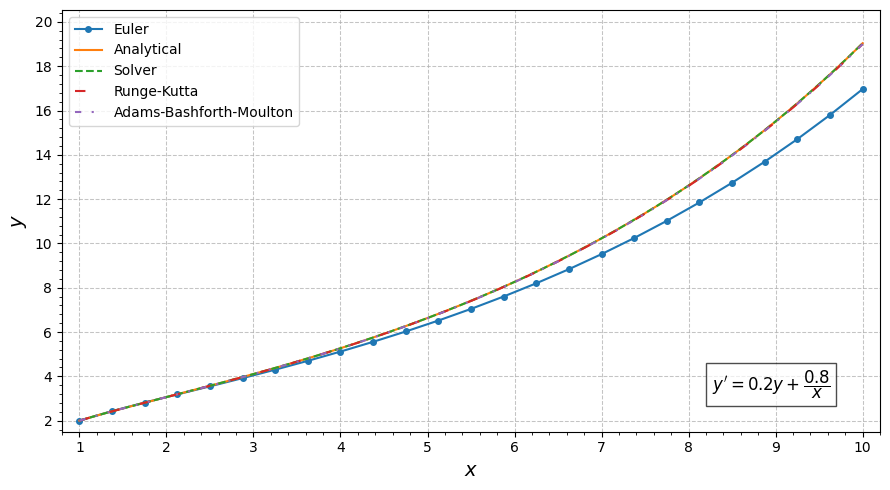

In [130]:
fig, ax = plt.subplots(figsize=(9, 5))
# plt.style.use('ggplot')

offset = 0.5
ymin = min(Y_euler.min(), Y_exact.min()) - offset
ymax = max(Y_euler.max(), Y_exact.max()) + 3 * offset
ax.set_ylim(ymin, ymax)
ax.set_xlim(START - 0.2, END + 0.2)

ax.set_xlabel(r"$x$", fontsize=14)
ax.set_ylabel(r"$y$", fontsize=14)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))

ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.4))

ax.grid(True, which="major", linestyle="--", linewidth=.75, alpha=.75)

colors = [plt.cm.tab10(i) for i in range(5)]

ax.plot(
    X_euler, Y_euler,
    color=colors[0],
    marker='o',
    markersize=4,
    label="Euler"
)

ax.plot(
    X_analytical, Y_analytical,
    color=colors[1],
    # linestyle="--",
    label="Analytical"
)

ax.plot(
    X_exact, Y_exact,
    color=colors[2],
    linestyle="--",
    label="Solver"
)

ax.plot(
    X_rk, Y_rk,
    color=colors[3],
    linestyle=(0, (5, 10)),
    label="Runge-Kutta"
)

ax.plot(
    X_adam, Y_adam,
    color=colors[4],
    linestyle=(0, (3, 5, 1, 5, 1, 5)),
    label="Adams-Bashforth-Moulton"
)

description = (
    r"$y' = 0.2y + \dfrac{0.8}{x}$"
)
ax.text(
    0.94, 0.15, description,
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=dict(facecolor="white", alpha=0.7)
)

plt.legend(loc='upper left')
plt.tight_layout()

plt.savefig('task1_plot.svg', format='svg')

plt.show()